In [114]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [115]:
%pip install decorator==5.0.9

import re
import imp
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


In [116]:
%pip install cltk==1.0.22

Note: you may need to restart the kernel to use updated packages.


In [117]:
# importing local modules

import sys
sys.path.append('../src/')

import text_cleanup.text_cleanup as thesisCleanUp
import preprocessing.text_preprocessing as thesisTextPreprocessing
import data.reader as thesisDataReader
import utils.utils as thesisUtils
import features.tf_idf.n_gram as thesisTfIdfNgramFeatures
import similarities.cosine as thesisCosineSimilarities
import vocabulary.vocabulary as thesisVocabulary
import features.lexical as thesisLexicalFeatures
import similarities.cosine as thesisCosineSimilarity
import text_cleanup.text_cleanup as thesisTextCleanUp

imp.reload(thesisLexicalFeatures)
imp.reload(thesisCosineSimilarity)
imp.reload(thesisCleanUp)
imp.reload(thesisTextPreprocessing)
imp.reload(thesisDataReader)
imp.reload(thesisUtils)
imp.reload(thesisTfIdfNgramFeatures)
imp.reload(thesisVocabulary)
imp.reload(thesisCosineSimilarities)
imp.reload(thesisTextCleanUp)

<module 'text_cleanup.text_cleanup' from '../src/text_cleanup/text_cleanup.py'>

# Data high level overview

Here we are looking at some properties of available data: like amount of paragraphs, words, characters, etc...


In [83]:
def data_high_level_overview():
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_corpus(), "zwickau"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_corpus(), "london"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_corpus(), "breslau")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers')
    
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_by_3_sentences(), "zwickau_3_sen"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_by_3_sentences(), "london_3_sen"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_by_3_sentences(), "breslau_3_sen")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers separated by 3 sentences')
    
    lexical_features_df = pd.concat([
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_zwickau_by_2_sentences(), "zwickau_2_sen"), 
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_london_by_2_sentences(), "london_2_sen"),
        thesisLexicalFeatures.create_lexical_features_df(thesisDataReader.get_breslau_by_2_sentences(), "breslau_2_sen")
    ])

    display(lexical_features_df)
    lexical_features_df.plot(kind="barh", figsize=(15, 5), title='text lexical features with all replacers separated by 2 sentences')

,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau,170609.0,26860.0,6063.0,321.0,4045.0
london,190575.0,30042.0,6509.0,317.0,4268.0
breslau,62525.0,9906.0,2953.0,71.0,2075.0


,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau_3_sen,170609.0,26860.0,6063.0,397.0,4045.0
london_3_sen,190575.0,30042.0,6509.0,428.0,4268.0
breslau_3_sen,62525.0,9906.0,2953.0,121.0,2075.0


,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
zwickau_2_sen,170609.0,26860.0,6063.0,417.0,4045.0
london_2_sen,190575.0,30042.0,6509.0,448.0,4268.0
breslau_2_sen,62525.0,9906.0,2953.0,130.0,2075.0


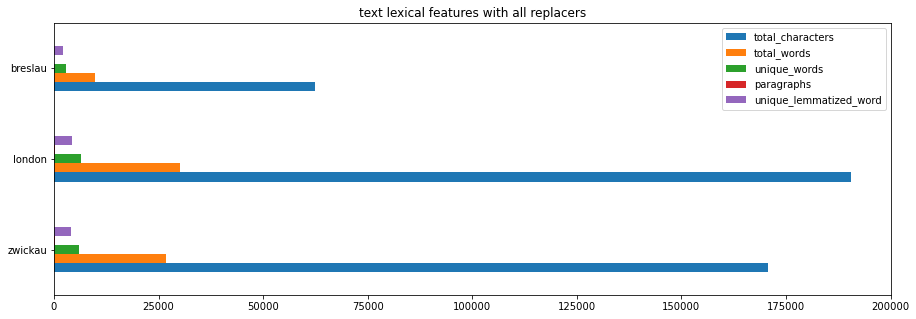

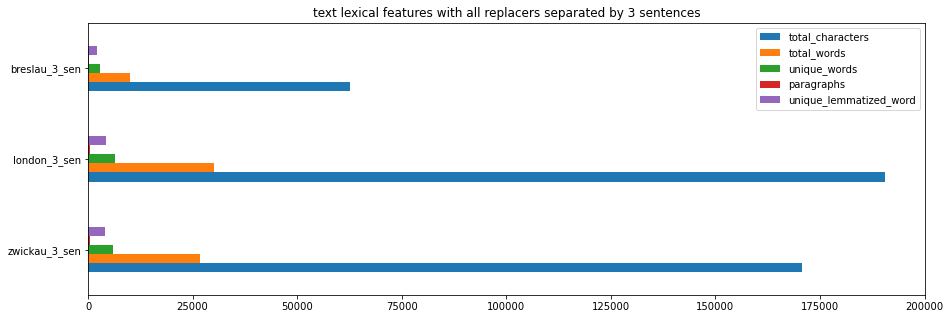

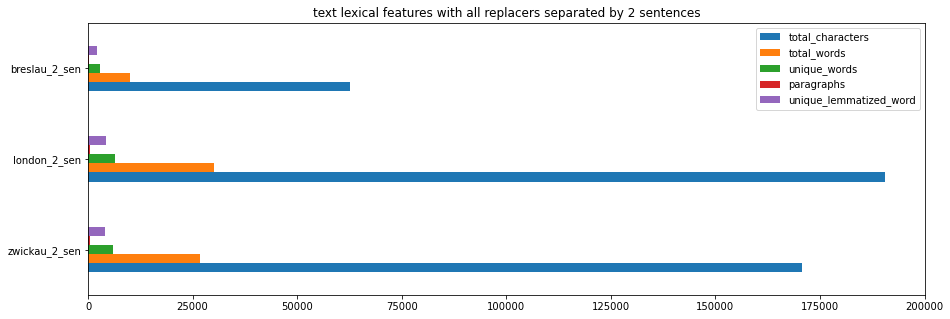

In [84]:
data_high_level_overview()

# Unique vocabulary
After our meeting 20.4, Yoni asked if we can have vocabulary of the words that appears in one version with counter bigger than 3 (for example) and does not appear in another 2 version

**UPDT**: cause unique vocabulary is very small for every version I choose threshold 1

In [307]:
def unique_vocabulary():
    df = thesisVocabulary.unique_vocabulary()
    df.to_csv('../computed_data/vocabulary/3_version_unique_vocabulary.csv')
    return df

In [308]:
unique_vocabulary()

,version,word,count
0,london,accepit,9
1,london,belonas,8
2,london,suanir,8
3,london,misit,7
4,london,aput,6
...,...,...,...
294,breslau,pares,2
295,breslau,urbes,2
296,breslau,diuisionis,2
297,breslau,arsur,2


# Shared vocabulary

Create vocabulary that shared in vesion a and b, but not in c - for all permutations

In [309]:
def shared_vocabulary():
    london_corpus = thesisDataReader.get_london_corpus()
    zwickau_corpus = thesisDataReader.get_zwickau_corpus()
    breslau_corpus = thesisDataReader.get_breslau_corpus()
    
    zwickau_london_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        zwickau_corpus, 'zwickau',
        london_corpus, 'london',
        breslau_corpus
    )
    london_zwickau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        london_corpus, 'london',
        zwickau_corpus, 'zwickau',
        breslau_corpus
    )
    zwickau_breslau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        zwickau_corpus, 'zwickau',
        breslau_corpus, 'breslau',
        london_corpus
    )
    london_breslau_shared_vocabulary = thesisVocabulary.get_shared_vocabulary_for_2_versions(
        london_corpus, 'london',
        breslau_corpus, 'breslau',
        zwickau_corpus
    )
    
    return [
        zwickau_london_shared_vocabulary,
        zwickau_breslau_shared_vocabulary,
        london_zwickau_shared_vocabulary,
        london_breslau_shared_vocabulary
    ]

def create_shared_vocabulary_df(shared_vocabulary):
    columns = [
        'shared_word', 
        'version a name', 
        'version a count',
        'version b name', 
        'version b count',
    ]
    all_data = []
    for shared_word in shared_vocabulary:
        data = [shared_word]
        
        for version_name in shared_vocabulary[shared_word]:
            data.append(version_name)
            data.append(shared_vocabulary[shared_word][version_name])
            
        all_data.append(data)
        
    return pd.DataFrame(all_data, columns=columns)

def create_shared_vocabulary_dfs():
    [
        zwickau_london_shared_vocabulary,
        zwickau_breslau_shared_vocabulary,
        london_zwickau_shared_vocabulary,
        london_breslau_shared_vocabulary
    ] = shared_vocabulary()
    
    zwickau_breslau_shared_vocabulary_df = create_shared_vocabulary_df(zwickau_breslau_shared_vocabulary)
    zwickau_breslau_shared_vocabulary_df.to_csv('../computed_data/vocabulary/shared_2_versions/zwickau_breslau.csv')
    display(zwickau_breslau_shared_vocabulary_df)
    
    london_zwickau_shared_vocabulary_df = create_shared_vocabulary_df(london_zwickau_shared_vocabulary)
    london_zwickau_shared_vocabulary_df.to_csv('../computed_data/vocabulary/shared_2_versions/london_zwickau.csv')
    display(london_zwickau_shared_vocabulary_df)
    
    london_breslau_shared_vocabulary_df = create_shared_vocabulary_df(london_breslau_shared_vocabulary)
    london_breslau_shared_vocabulary_df.to_csv('../computed_data/vocabulary/shared_2_versions/london_breslau.csv')
    display(london_breslau_shared_vocabulary_df)

In [310]:
create_shared_vocabulary_dfs()

,shared_word,version a name,version a count,version b name,version b count
0,lempna,zwickau,8,breslau,1
1,israhel,zwickau,6,breslau,4
2,corrosaim,zwickau,6,breslau,5
3,engadi,zwickau,5,breslau,3
4,ceila,zwickau,4,breslau,4
...,...,...,...,...,...
159,tamem,zwickau,1,breslau,1
160,placuerit,zwickau,1,breslau,1
161,fures,zwickau,1,breslau,1
162,io,zwickau,1,breslau,1


,shared_word,version a name,version a count,version b name,version b count
0,iacere,london,19,zwickau,14
1,longum,london,15,zwickau,10
2,oppidum,london,15,zwickau,1
3,ueni,london,15,zwickau,10
4,campo,london,13,zwickau,7
...,...,...,...,...,...
2794,terrere,london,1,zwickau,1
2795,margat,london,1,zwickau,2
2796,ualaniam,london,1,zwickau,1
2797,doram,london,1,zwickau,1


,shared_word,version a name,version a count,version b name,version b count
0,pilistiim,london,11,breslau,2
1,deinde,london,9,breslau,10
2,quatuor,london,8,breslau,4
3,acconensi,london,6,breslau,1
4,magedo,london,6,breslau,1
...,...,...,...,...,...
149,ueneratione,london,1,breslau,2
150,inquit,london,1,breslau,1
151,nouam,london,1,breslau,1
152,ramatam,london,1,breslau,1


# statistics df: compares version similarity mean score in order to determinate if version more similar to self or to compared version

In [151]:
def check_inner_cross_mean(statistics_df, version_name):
    features = statistics_df.feature_name.unique()
    
    for feature in features:
        total = 0
        
        version_inner_df = statistics_df.loc[
            (statistics_df['cross/inner'] == 'inner') &
            (statistics_df['version'] == version_name) & 
            (statistics_df['feature_name'] == feature)
        ]
        version_cross_df = statistics_df.loc[
            (statistics_df['cross/inner'] == 'cross') &
            (statistics_df['version'] == version_name) & 
            (statistics_df['feature_name'] == feature)
        ]
        
        for i, d in version_cross_df.iterrows():
            cross_mean_val = d['mean']
            p_index = d['p_#']
            inner_mean_val = version_inner_df.loc[
                (version_inner_df['p_#'] == p_index) &
                (version_inner_df['feature_name'] == feature),
                'mean'
            ].values[0]
            
            cross_inner_mean_diff = cross_mean_val - inner_mean_val
            if cross_inner_mean_diff > 0:
                statistics_df.loc[
                    (statistics_df['version'] == version_name) &
                    (statistics_df['cross/inner'] == 'inner') &
                    (statistics_df['p_#'] == p_index) & 
                    (statistics_df['feature_name'] == feature),
                    'more_simmilar_to_compared'
                ] = True
            else:
                statistics_df.loc[
                    (statistics_df['version'] == version_name) &
                    (statistics_df['cross/inner'] == 'inner') &
                    (statistics_df['p_#'] == p_index) & 
                    (statistics_df['feature_name'] == feature),
                    'more_simmilar_to_compared'
                ] = False
                total += 1
            statistics_df.loc[
                (statistics_df['version'] == version_name) &
                (statistics_df['cross/inner'] == 'inner') &
                (statistics_df['p_#'] == p_index) & 
                (statistics_df['feature_name'] == feature),
                'cross_inner_mean_diff'
                ] = cross_inner_mean_diff
            
        print(f'version: {version_name}, for feature: {feature}, number of inner lowe that cross is: {total}')
        
def similar_to_self_or_to_compared(zwickau_corpus, london_corpus, breslau_corpus):    
    statistics_df_zwickau_to_london = thesisCosineSimilarity.create_statistics_df(
        zwickau_corpus, 
        london_corpus, 
        'zwickau_to_london'
    )
    statistics_df_zwickau_to_breslau = thesisCosineSimilarity.create_statistics_df(
        zwickau_corpus, 
        breslau_corpus, 
        'zwickau_to_breslau'
    )
    
    statistics_df_london_to_zwickau = thesisCosineSimilarity.create_statistics_df(
        london_corpus, 
        zwickau_corpus, 
        'london_to_zwickau'
    )
    statistics_df_london_to_breslau = thesisCosineSimilarity.create_statistics_df(
        london_corpus, 
        breslau_corpus, 
        'london_to_breslau'
    )
    statistics_df_breslau_to_zwickau = thesisCosineSimilarity.create_statistics_df(
        breslau_corpus, 
        zwickau_corpus, 
        'breslau_to_zwickau'
    )
    statistics_df_breslau_to_london = thesisCosineSimilarity.create_statistics_df(
        breslau_corpus, 
        london_corpus, 
        'breslau_to_london'
    )
    
    statistics_df_combined = pd.concat([
        statistics_df_zwickau_to_london, 
        statistics_df_zwickau_to_breslau,
        statistics_df_london_to_zwickau,
        statistics_df_london_to_breslau,
        statistics_df_breslau_to_zwickau,
        statistics_df_breslau_to_london,
    ])
    
    check_inner_cross_mean(statistics_df_combined, 'zwickau_to_london')
    check_inner_cross_mean(statistics_df_combined, 'zwickau_to_breslau')
    
    check_inner_cross_mean(statistics_df_combined, 'london_to_zwickau')
    check_inner_cross_mean(statistics_df_combined, 'london_to_breslau')
    
    check_inner_cross_mean(statistics_df_combined, 'breslau_to_zwickau')
    check_inner_cross_mean(statistics_df_combined, 'breslau_to_london')
    
    return statistics_df_combined

In [152]:
statistics_df = similar_to_self_or_to_compared(
    thesisDataReader.get_zwickau_corpus(),
    thesisDataReader.get_london_corpus(),
    thesisDataReader.get_breslau_corpus()
)
statistics_df

version: zwickau_to_london, for feature: 5_gram, number of inner lowe that cross is: 15
version: zwickau_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 0
version: london_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 279
version: london_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 1
version: breslau_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 71
version: breslau_to_london, for feature: 5_gram, number of inner lowe that cross is: 71


,feature_name,p_#,cross/inner,mean,std,min,25%,50%,75%,max,...,most_similar_p_#,most_similar_score,most_similar_p_length,most_similar_dropped,most_similar_dropped_p_#,most_similar_dropperd_score,most_similar_dropped_p_length,version,more_simmilar_to_compared,cross_inner_mean_diff
0,5_gram,0,inner,0.009503,0.018005,0.000000,0.000000,0.002609,0.011606,0.159225,...,320,0.159225,53,None,NaN,NaN,NaN,zwickau_to_london,True,0.001758
1,5_gram,1,inner,0.032343,0.018099,0.000000,0.018490,0.030228,0.042233,0.103204,...,6,0.103204,1578,None,NaN,NaN,NaN,zwickau_to_london,True,0.002302
2,5_gram,2,inner,0.023968,0.014803,0.000000,0.013667,0.021623,0.032216,0.099063,...,211,0.099063,411,None,NaN,NaN,NaN,zwickau_to_london,True,0.001047
3,5_gram,3,inner,0.030280,0.017046,0.000000,0.017822,0.029289,0.039827,0.102587,...,168,0.102587,1499,None,NaN,NaN,NaN,zwickau_to_london,True,0.002040
4,5_gram,4,inner,0.027132,0.017271,0.000000,0.015075,0.024053,0.035905,0.114511,...,278,0.114511,1007,None,NaN,NaN,NaN,zwickau_to_london,True,0.001175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,5_gram,66,cross,0.039565,0.037914,0.000000,0.020566,0.030437,0.044622,0.479348,...,200,0.479348,328,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
138,5_gram,67,cross,0.042295,0.034790,0.000000,0.024841,0.035565,0.047674,0.357403,...,201,0.357403,522,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
139,5_gram,68,cross,0.028837,0.031707,0.000000,0.013405,0.022573,0.034343,0.442933,...,202,0.442933,417,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
140,5_gram,69,cross,0.053503,0.043016,0.000000,0.030742,0.043439,0.060888,0.477705,...,203,0.477705,517,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN


In [153]:
statistics_df.to_csv('../computed_data/statistics/3_versions_by_new_line.csv')

In [154]:
statistics_df_by_3_sentences = similar_to_self_or_to_compared(
    thesisDataReader.get_zwickau_by_3_sentences(),
    thesisDataReader.get_london_by_3_sentences(),
    thesisDataReader.get_breslau_by_3_sentences()
)
statistics_df_by_3_sentences

version: zwickau_to_london, for feature: 5_gram, number of inner lowe that cross is: 60
version: zwickau_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 12
version: london_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 276
version: london_to_breslau, for feature: 5_gram, number of inner lowe that cross is: 19
version: breslau_to_zwickau, for feature: 5_gram, number of inner lowe that cross is: 119
version: breslau_to_london, for feature: 5_gram, number of inner lowe that cross is: 118


,feature_name,p_#,cross/inner,mean,std,min,25%,50%,75%,max,...,most_similar_p_#,most_similar_score,most_similar_p_length,most_similar_dropped,most_similar_dropped_p_#,most_similar_dropperd_score,most_similar_dropped_p_length,version,more_simmilar_to_compared,cross_inner_mean_diff
0,5_gram,0,inner,0.008729,0.017075,0.000000,0.000000,0.001821,0.010824,0.161337,...,396,0.161337,53,None,NaN,NaN,NaN,zwickau_to_london,True,0.001323
1,5_gram,1,inner,0.031004,0.015918,0.000000,0.018854,0.029477,0.040074,0.103852,...,6,0.103852,1578,None,NaN,NaN,NaN,zwickau_to_london,True,0.001133
2,5_gram,2,inner,0.022773,0.013597,0.000000,0.013501,0.020234,0.029781,0.099285,...,239,0.099285,411,None,NaN,NaN,NaN,zwickau_to_london,True,0.000402
3,5_gram,3,inner,0.028436,0.016113,0.000000,0.016786,0.025948,0.036850,0.104127,...,5,0.104127,1235,None,NaN,NaN,NaN,zwickau_to_london,True,0.001259
4,5_gram,4,inner,0.025930,0.015582,0.000000,0.015589,0.023386,0.032646,0.115363,...,327,0.115363,1583,None,NaN,NaN,NaN,zwickau_to_london,True,0.000435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,5_gram,116,cross,0.031523,0.032730,0.000000,0.016034,0.024613,0.037334,0.399778,...,250,0.399778,522,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
238,5_gram,117,cross,0.024467,0.019757,0.000000,0.012080,0.019646,0.030576,0.139911,...,205,0.139911,352,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
239,5_gram,118,cross,0.026302,0.028238,0.000000,0.013048,0.020790,0.032206,0.442968,...,251,0.442968,417,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN
240,5_gram,119,cross,0.049209,0.038628,0.000000,0.029027,0.040283,0.055145,0.476707,...,252,0.476707,517,False,NaN,NaN,NaN,breslau_to_london,NaN,NaN


In [155]:
statistics_df_by_3_sentences.to_csv('../computed_data/statistics/3_versions_by_3_sentences.csv')

# p aligment by 5_gram split to 3 sentences

During last meeting 20.4 we saw that paragraphs that aligned together, has very different lenght (very short VS very long) we are thinking that it is happend because up till now we created corpus based on \n split, so we said that we will try to split each paragraph to 3 sentences, if paragraph is 4 or 5 sentences we will keep them together

In [323]:
london_corpus = thesisDataReader.get_london_by_3_sentences()
zwickau_corpus = thesisDataReader.get_zwickau_by_3_sentences()
breslau_corpus = thesisDataReader.get_breslau_by_3_sentences()

In [324]:
# zwickau_london_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(zwickau_corpus, london_corpus)
# zwickau_breslau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(zwickau_corpus, breslau_corpus)

# london_zwickau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(london_corpus, zwickau_corpus)
# london_breslau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(london_corpus, breslau_corpus)

# breslau_zwickau_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(breslau_corpus, zwickau_corpus)
# breslau_london_similarities = thesisCosineSimilarities.cross_version_similarity_5_gram(breslau_corpus, london_corpus)

In [325]:
# np.save('../computed_data/similarities/cross_version/sentences_by_3/zwickau_london_similarities.npy', zwickau_london_similarities)
# np.save('../computed_data/similarities/cross_version/sentences_by_3/zwickau_breslau_similarities.npy', zwickau_breslau_similarities)

# np.save('../computed_data/similarities/cross_version/sentences_by_3/london_zwickau_similarities.npy', london_zwickau_similarities)
# np.save('../computed_data/similarities/cross_version/sentences_by_3/london_breslau_similarities.npy', london_breslau_similarities)

# np.save('../computed_data/similarities/cross_version/sentences_by_3/breslau_zwickau_similarities.npy', breslau_zwickau_similarities)
# np.save('../computed_data/similarities/cross_version/sentences_by_3/breslau_london_similarities.npy', breslau_london_similarities)

In [326]:
# zwickau_london_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(zwickau_london_similarities)
# zwickau_breslau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(zwickau_breslau_similarities)

# london_zwickau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(london_zwickau_similarities)
# london_breslau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(london_breslau_similarities)

# breslau_zwickau_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(breslau_zwickau_similarities)
# breslau_london_max_similarity_per_p = thesisUtils.get_max_similarity_per_p(breslau_london_similarities)

In [327]:
zwickau_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, breslau_corpus)
zwickau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, london_corpus)

In [328]:
london_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, breslau_corpus)
london_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, zwickau_corpus)

In [329]:
breslau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, london_corpus)
breslau_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, zwickau_corpus)

In [330]:
def create_5_gram_text_aligments(original_version, version_1, best_matches_1, version_2, best_matches_2):
    p_aligment = []
    
    for i, best_match_1 in enumerate(best_matches_1):
        best_match_2 = best_matches_2[i]
        
        best_match_1_p, best_match_1_score = best_match_1['5_gram']
        best_match_2_p, best_match_2_score = best_match_2['5_gram']
        
        data = [
            original_version[i],
            
            version_1[best_match_1_p],
            best_match_1_p,
            best_match_1_score,
        
            version_2[best_match_2_p],
            best_match_2_p,
            best_match_2_score
        ]
        
        p_aligment.append(data)
    return p_aligment

In [331]:
def create_zwickau_p_aligment(
    zwickau_corpus,
    london_corpus,
    zwickau_london_best_smlrt,
    breslau_corpus,
    zwickau_breslau_best_smlrt,
):
    columns = [
        'zwickau text',
        'london text',
        'london p#',
        'london score',
        'breslau text',
        'breslau p#',
        'breslau score'
    ]
    p_aligment = create_5_gram_text_aligments(
        zwickau_corpus,
        london_corpus,
        zwickau_london_best_smlrt,
        breslau_corpus,
        zwickau_breslau_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)
    

In [332]:
def create_london_p_aligment(
    london_corpus, 
    zwickau_corpus, 
    london_zwickau_best_smlrt, 
    breslau_corpus, 
    london_breslau_best_smlrt
):
    columns = [
        'london text',
        'zwickau text',
        'zwickau p#',
        'zwickau score',
        'breslau text',
        'breslau p#',
        'breslau score'
    ]
    p_aligment = create_5_gram_text_aligments(
        london_corpus,
        zwickau_corpus,
        london_zwickau_best_smlrt,
        breslau_corpus,
        london_breslau_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)

In [333]:
def create_breslau_p_aligment(
    breslau_corpus,
    zwickau_corpus, 
    breslau_zwickau_best_smlrt,
    london_corpus,
    breslau_london_best_smlrt,
):
    columns = [
        'breslau text',
        'zwickau text',
        'zwickau p#',
        'zwickau score',
        'london text',
        'london p#',
        'london score'
    ]
    p_aligment = create_5_gram_text_aligments(
        breslau_corpus,
        zwickau_corpus,
        breslau_zwickau_best_smlrt,
        london_corpus,
        breslau_london_best_smlrt
    )
    return pd.DataFrame(p_aligment, columns=columns)

In [334]:
zwickau_p_aligment_df = create_zwickau_p_aligment(    
    zwickau_corpus,
    london_corpus,
    zwickau_london_best_smlrt,
    breslau_corpus,
    zwickau_breslau_best_smlrt
)
london_p_aligment_df = create_london_p_aligment(
    london_corpus, 
    zwickau_corpus, 
    london_zwickau_best_smlrt, 
    breslau_corpus, 
    london_breslau_best_smlrt
)
breslau_p_aligment_df = create_breslau_p_aligment(
    breslau_corpus,
    zwickau_corpus, 
    breslau_zwickau_best_smlrt,
    london_corpus,
    breslau_london_best_smlrt,
)

In [335]:
zwickau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/zwickau_london_breslau.csv')
london_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/london_zwickau_breslau.csv')
breslau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')

<AxesSubplot:title={'center':'zwickau p aligment similarity score (by new line)'}>

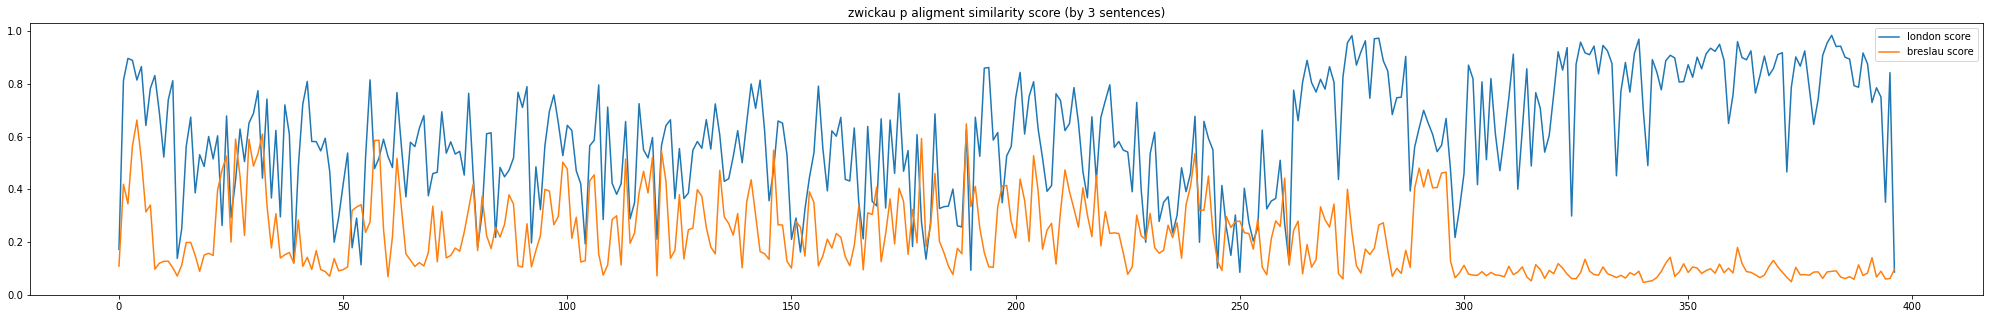

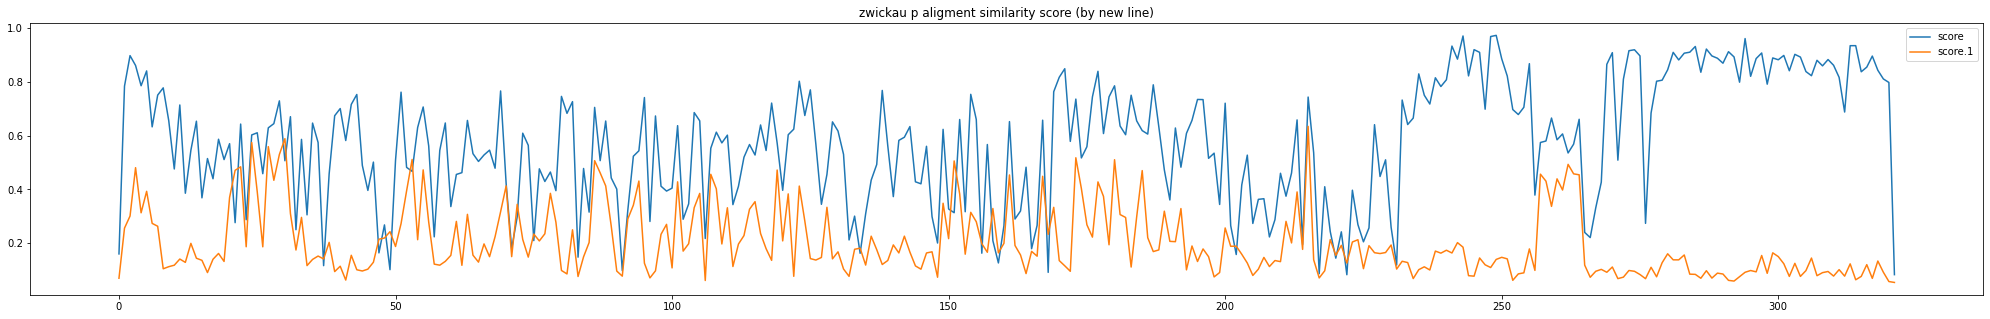

In [339]:
zwickau_p_aligment_df[['london score', 'breslau score']].plot(figsize=(35, 5), title='zwickau p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/zwickau_london_breslau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='zwickau p aligment similarity score (by new line)')

In [340]:
display(zwickau_p_aligment_df[['london score', 'breslau score']].describe())
display(pd.read_csv('../computed_data/p_aligment/zwickau_london_breslau.csv')[['score', 'score.1']].describe())

,london score,breslau score
count,397.000000,397.000000
mean,0.600405,0.215451
std,0.223143,0.141358
min,0.084326,0.046012
25%,0.440112,0.099519
50%,0.609555,0.167717
75%,0.785932,0.307077
max,0.984323,0.662518


,score,score.1
count,322.000000,322.000000
mean,0.576689,0.201493
std,0.226696,0.125397
min,0.082701,0.054012
25%,0.411374,0.105889
50%,0.601789,0.160958
75%,0.752913,0.263367
max,0.972249,0.633956


<AxesSubplot:title={'center':'london p aligment similarity score (by new line)'}>

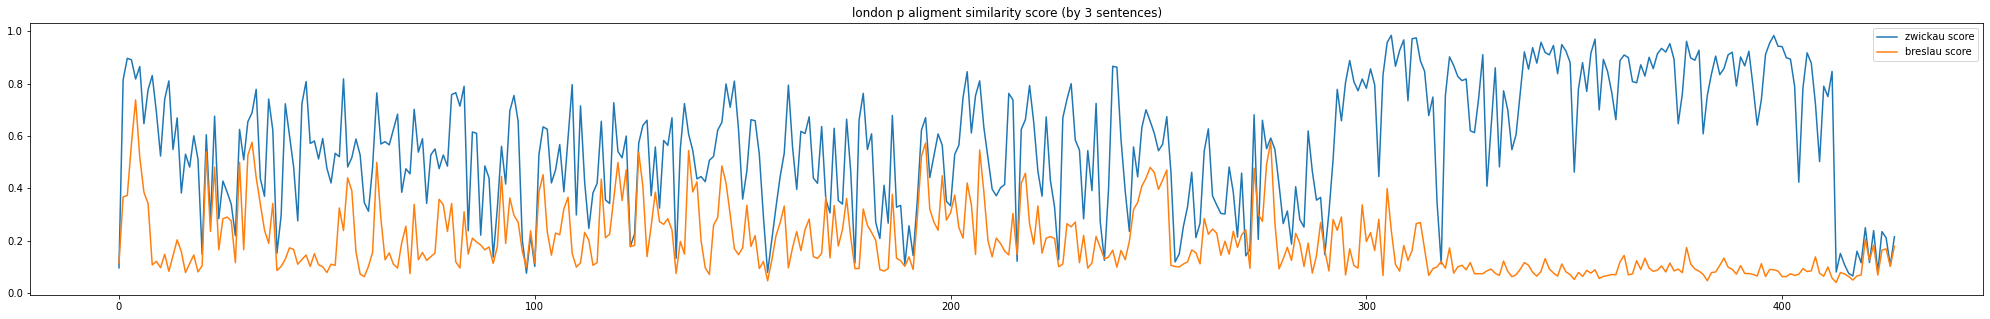

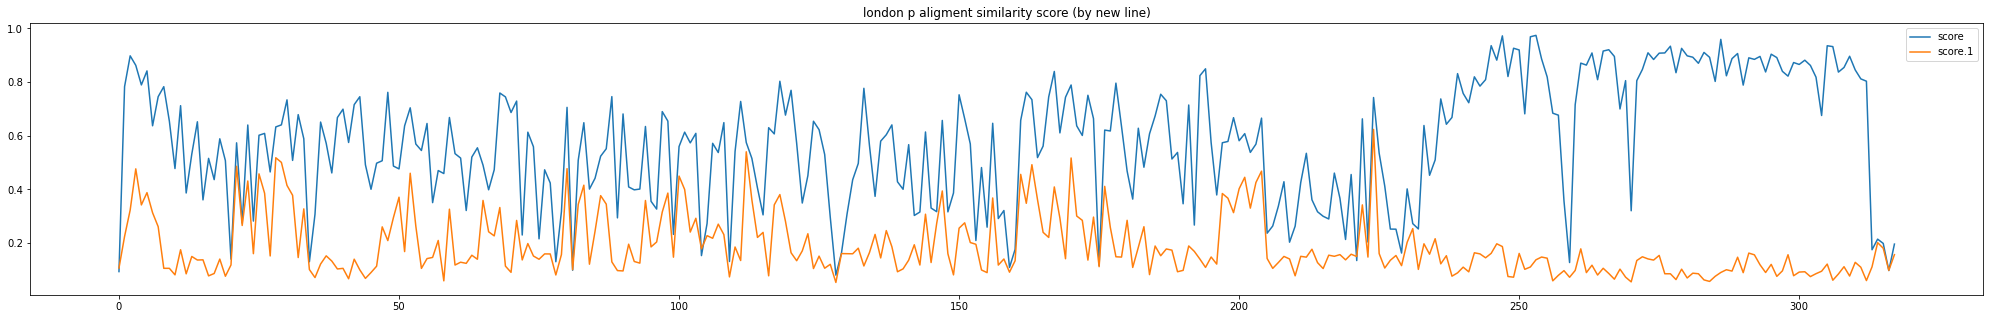

In [342]:
london_p_aligment_df[['zwickau score', 'breslau score']].plot(figsize=(35, 5), title='london p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/london_zwickau_breslau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='london p aligment similarity score (by new line)')

In [343]:
display(london_p_aligment_df[['zwickau score', 'breslau score']].describe())
display(pd.read_csv('../computed_data/p_aligment/london_zwickau_breslau.csv')[['score', 'score.1']].describe())

,zwickau score,breslau score
count,428.000000,428.000000
mean,0.572973,0.193357
std,0.239810,0.127257
min,0.064448,0.039787
25%,0.390601,0.094712
50%,0.589869,0.150998
75%,0.773610,0.259587
max,0.984409,0.737676


,score,score.1
count,318.000000,318.000000
mean,0.580992,0.186445
std,0.226031,0.113091
min,0.080923,0.053676
25%,0.406627,0.105578
50%,0.606969,0.148378
75%,0.758824,0.234428
max,0.973818,0.623667


<AxesSubplot:title={'center':'breslau p aligment similarity score (by new line)'}>

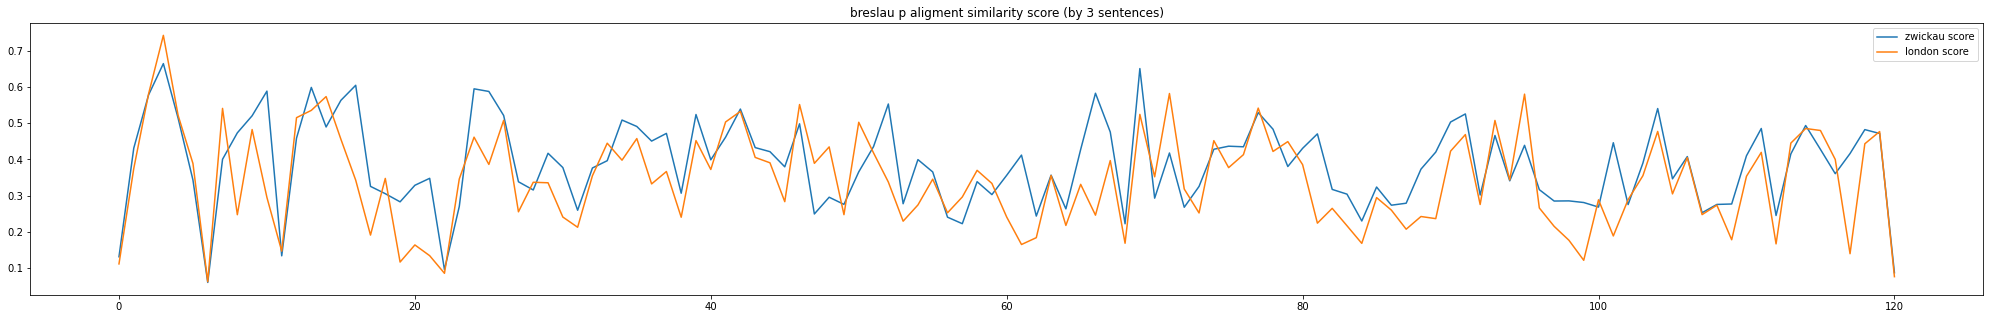

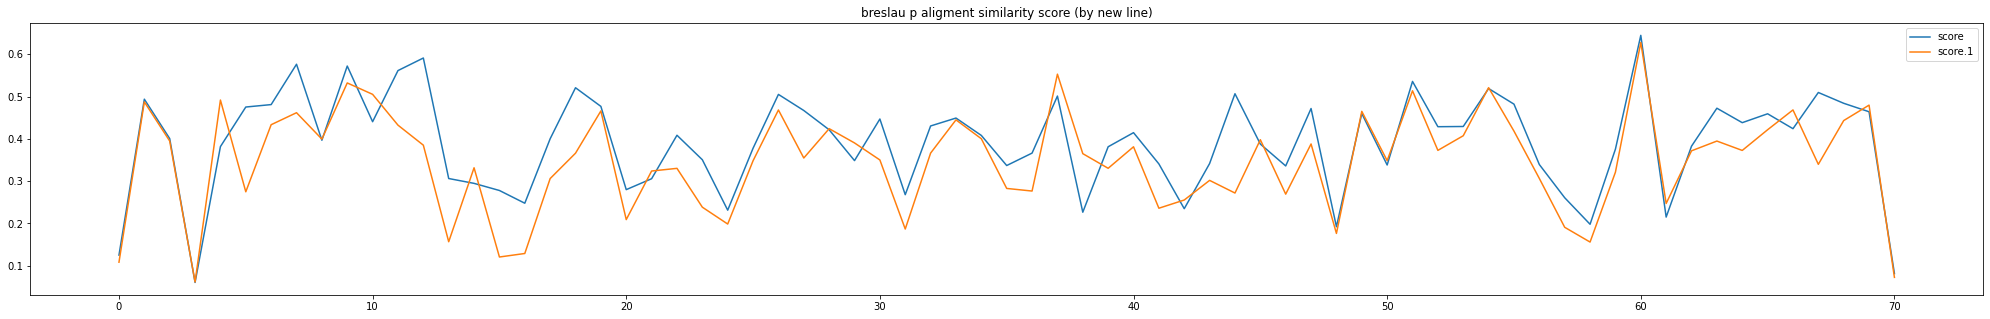

In [346]:
breslau_p_aligment_df[['zwickau score', 'london score']].plot(figsize=(35, 5), title='breslau p aligment similarity score (by 3 sentences)')
pd.read_csv('../computed_data/p_aligment/breslau_london_zwickau.csv')[['score', 'score.1']].plot(figsize=(35, 5), title='breslau p aligment similarity score (by new line)')

In [347]:
display(breslau_p_aligment_df[['zwickau score', 'london score']].describe())
display(pd.read_csv('../computed_data/p_aligment/breslau_london_zwickau.csv')[['score', 'score.1']].describe())

,zwickau score,london score
count,121.000000,121.000000
mean,0.386878,0.341399
std,0.119953,0.132525
min,0.060756,0.062778
25%,0.295636,0.242494
50%,0.396302,0.345401
75%,0.471546,0.444543
max,0.663903,0.741780


,score,score.1
count,71.000000,71.000000
mean,0.390881,0.346706
std,0.119141,0.121027
min,0.060284,0.061426
25%,0.336308,0.273221
50%,0.407957,0.365997
75%,0.473754,0.428147
max,0.644676,0.627791


# p aligment by 5_gram split by new line

In [348]:
zwickau_corpus = thesisDataReader.get_zwickau_corpus()
london_corpus = thesisDataReader.get_london_corpus()
breslau_corpus = thesisDataReader.get_breslau_corpus()

In [349]:
zwickau_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, breslau_corpus)
zwickau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(zwickau_corpus, london_corpus)

In [350]:
london_breslau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, breslau_corpus)
london_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(london_corpus, zwickau_corpus)

In [351]:
breslau_london_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, london_corpus)
breslau_zwickau_best_smlrt = thesisCosineSimilarities.get_cross_version_best_similarities(breslau_corpus, zwickau_corpus)

In [352]:
zwickau_p_aligment_df = create_zwickau_p_aligment(    
    zwickau_corpus,
    london_corpus,
    zwickau_london_best_smlrt,
    breslau_corpus,
    zwickau_breslau_best_smlrt
)
london_p_aligment_df = create_london_p_aligment(
    london_corpus, 
    zwickau_corpus, 
    london_zwickau_best_smlrt, 
    breslau_corpus, 
    london_breslau_best_smlrt
)
breslau_p_aligment_df = create_breslau_p_aligment(
    breslau_corpus,
    zwickau_corpus, 
    breslau_zwickau_best_smlrt,
    london_corpus,
    breslau_london_best_smlrt,
)

In [353]:
zwickau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_new_line/zwickau_london_breslau.csv')
london_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_new_line/london_zwickau_breslau.csv')
breslau_p_aligment_df.to_csv('../computed_data/p_aligment/sentences_by_new_line/breslau_london_zwickau.csv')

# words counts

In [51]:
def create_n_gram_frequency(n_gram, corpus):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), analyzer='char').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq

def creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words,
    
    corpus_2, 
    corpus_2_name, 
    corpus_2_total_words,
    
    corpus_3,
    corpus_3_name,
    corpus_3_total_words,
    
    n_gram
):    
    dictionary = {}
    
    counter_sorted_corpus_1 = create_n_gram_frequency(n_gram, corpus_1)
    counter_sorted_corpus_2 = create_n_gram_frequency(n_gram, corpus_2)
    counter_sorted_corpus_3 = create_n_gram_frequency(n_gram, corpus_3)
    
    def add_to_dictionary(counters, corpus_name):
        for i in counters:
            word = i[0].replace(' ', '_')
            count = i[1]
            if word not in dictionary:
                dictionary[word] = {}
            dictionary[word][corpus_name] = count

    add_to_dictionary(counter_sorted_corpus_1, corpus_1_name)
    add_to_dictionary(counter_sorted_corpus_2, corpus_2_name)
    add_to_dictionary(counter_sorted_corpus_3, corpus_3_name)
    
    return create_data(
        dictionary, 
        corpus_1_name, 
        corpus_2_name,  
        corpus_3_name,
        f'count_vectorizer_{n_gram}_gram',
        corpus_1_total_words,
        corpus_2_total_words,
        corpus_3_total_words
    )

# # here is neat graph for count: https://www.absentdata.com/python-graphs/python-word-frequency/
def create_words_frequency(corpus):    
    word_counter =  Counter(' '.join(corpus).split())
    return sorted(word_counter.items(), key=lambda item: item[1], reverse=True)

def create_data(
    dictionary, 
    corpus_1_name, 
    corpus_2_name, 
    corpus_3_name,
    feature_name,
    corpus_1_total_words,
    corpus_2_total_words,
    corpus_3_total_words,
):
    data = []
    for i in dictionary:
        corpus_1_counter = 0 if corpus_1_name not in dictionary[i] else dictionary[i][corpus_1_name]
        corpus_2_counter = 0 if corpus_2_name not in dictionary[i] else dictionary[i][corpus_2_name]
        corpus_3_counter = 0 if corpus_3_name not in dictionary[i] else dictionary[i][corpus_3_name]
        
        all_counters = [corpus_1_counter, corpus_2_counter, corpus_3_counter]
        all_names = [corpus_1_name, corpus_2_name, corpus_3_name]
        max_version_name = all_names[np.argmax(all_counters)]
        
        corpus_1_counter_norm = corpus_1_counter / corpus_1_total_words
        corpus_2_counter_norm = corpus_2_counter / corpus_2_total_words
        corpus_3_counter_norm = corpus_3_counter / corpus_3_total_words
        
        data.append([
            feature_name,
            i,
            
            corpus_1_counter,
            corpus_1_counter_norm,
            
            corpus_2_counter,
            corpus_2_counter_norm,
            
            corpus_3_counter,
            corpus_3_counter_norm,
            
            get_ration_between_norms(corpus_1_counter_norm, corpus_2_counter_norm),
            get_ration_between_norms(corpus_1_counter_norm, corpus_3_counter_norm),
            get_ration_between_norms(corpus_2_counter_norm, corpus_3_counter_norm),
            
            max_version_name,
        ])
    return data

def get_ration_between_norms(norm_1, norm_2):
    if norm_1 == norm_2:
        return 1
    elif  norm_2 == 0:
        return 0
    
    return norm_1 / norm_2
        

def creat_word_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words,
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3,
    corpus_3_name,
    corspus_3_total_words
):    
    dictionary = {}
    
    counter_sorted_corpus_1 = create_words_frequency(corpus_1)
    counter_sorted_corpus_2 = create_words_frequency(corpus_2)
    counter_sorted_corpus_3 = create_words_frequency(corpus_3)
    
    def add_to_dictionary(counters, corpus_name):
        for i in counters:
            word = i[0]
            count = i[1]
            if word not in dictionary:
                dictionary[word] = {}
            dictionary[word][corpus_name] = count

    add_to_dictionary(counter_sorted_corpus_1, corpus_1_name)
    add_to_dictionary(counter_sorted_corpus_2, corpus_2_name)
    add_to_dictionary(counter_sorted_corpus_3, corpus_3_name)

    data = []
    return create_data(
        dictionary, 
        corpus_1_name, 
        corpus_2_name,
        corpus_3_name,
        'word_counter',
        corpus_1_total_words,
        corpus_2_total_words,
        corspus_3_total_words
    )

def creat_5_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
     
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words
):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 
    5
)

def creat_6_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words
):
    return creat_n_gram_frequency_data(    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,    
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 6)

def creat_7_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
       
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 7)

def creat_8_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
       
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 8)

def creat_9_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
      
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
     
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 9)

def creat_10_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
       
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words):
    return creat_n_gram_frequency_data(
    corpus_1, 
    corpus_1_name, 
    corpus_1_total_words, 
    
    corpus_2, 
    corpus_2_name,
    corpus_2_total_words,
    
    corpus_3, 
    corpus_3_name,
    corpus_3_total_words, 10)

def words_counts(zwickau_total_words, london_total_words, breslau_total_words):
    zwickau_corpus = thesisDataReader.get_zwickau_corpus()
    london_corpus = thesisDataReader.get_london_corpus()
    breslau_corpus = thesisDataReader.get_breslau_corpus()
    
    word_freq = creat_word_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        london_corpus,
        'london',
        london_total_words,
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    
    gram_5_frequency = creat_5_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words,
        
    )
    gram_6_frequency = creat_6_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_7_frequency = creat_7_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_8_frequency = creat_8_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_9_frequency = creat_9_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    gram_10_frequency = creat_10_gram_frequency_data(
        zwickau_corpus,
        'zwickau',
        zwickau_total_words,
        
        london_corpus,
        'london',
        london_total_words,
        
        breslau_corpus,
        'breslau',
        breslau_total_words
    )
    
    df_columns = [
    'feature_name', 
    'word',
        
    'zwickau', 
    'zwickau norm.',
        
    'london',
    'london norm.',
        
    'breslau',
    'breslau norm.',
        
    'zwickau / london',
    'zwickau / breslau',
    'london / breslau',
        
    'version with higher score',
    ]

    words_df = pd.DataFrame(
        word_freq + gram_5_frequency + gram_6_frequency + gram_7_frequency + gram_8_frequency + gram_9_frequency + gram_10_frequency,
        columns=df_columns
    )
    return words_df

In [52]:
zwickau_total_words = 26860
london_total_words = 30042
breslau_total_words = 9906

words_df = words_counts(zwickau_total_words, london_total_words, breslau_total_words)

In [53]:
words_df

,feature_name,word,zwickau,zwickau norm.,london,london norm.,breslau,breslau norm.,zwickau / london,zwickau / breslau,london / breslau,version with higher score
0,word_counter,et,1524,0.056739,1687,0.056155,494,0.049869,1.010399,1.137759,1.126050,london
1,word_counter,in,1043,0.038831,1149,0.038246,380,0.038361,1.015283,1.012262,0.997025,london
2,word_counter,est,601,0.022375,674,0.022435,207,0.020896,0.997327,1.070771,1.073641,london
3,word_counter,de,459,0.017089,531,0.017675,185,0.018676,0.966810,0.915026,0.946438,london
4,word_counter,ad,427,0.015897,441,0.014679,253,0.025540,1.082959,0.622443,0.574761,london
...,...,...,...,...,...,...,...,...,...,...,...,...
848256,count_vectorizer_10_gram,corrige_le,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau
848257,count_vectorizer_10_gram,orrige_lec,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau
848258,count_vectorizer_10_gram,rrige_lect,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau
848259,count_vectorizer_10_gram,rige_lecto,0,0.000000,0,0.000000,1,0.000101,1.000000,0.000000,0.000000,breslau


In [54]:
for feature_name in [
    'word_counter',
    'count_vectorizer_5_gram',
    'count_vectorizer_6_gram',
    'count_vectorizer_7_gram',
    'count_vectorizer_8_gram',
    'count_vectorizer_9_gram',
    'count_vectorizer_10_gram'
]:
    words_df[
        words_df['feature_name'] == feature_name
    ].to_csv(f'../computed_data/words_count/{feature_name}.csv')

# p aligment on shared vocabulary
in our last meeting at 3.4.22 we found interesting pattern that for example word sinai not appears in one of the version (london or zwickau), it is interesting cause it can make show us that maybe one version does not include specific part at all or it has but using different vocabulary to describe the same event.
So we decided to take shared vocabulary and run p aligment for them in order to be able easily see those paragraphs.

In [131]:
word_to_find = "hello"
s = "I wanna say hello world hello"
re_resp = re.finditer(r'\b' + word_to_find + r'\b', s)
# re_resp.span()
# if re_resp is not None:
#     [start_match, end_match] = re_resp.span()
#     s = s[0:start_match] + '**' + s[start_match:start_match + len(word_to_find)] + '**' + s[end_match:len(s)]
# print(s)
re_resp
for match in re.finditer(r'\b' + word_to_find + r'\b', s):
    [start_match, end_match] = match.span()
    s = s[0:start_match] + '**' + s[start_match:start_match + len(word_to_find)] + '**' + s[end_match:len(s)]
s

'I wanna say **hello** wo**rld h**ello'

In [132]:
def create_p_aligment_df_with_shared_words(
    shared_vocabulary_df, 
    p_aligment_df, 
    corpus, 
    shared_word_meaning, 
    version_count, 
    version_a_name, 
    version_b_name, 
    version_c_name
):
    relevant_ps = []
    by_words = {}
    by_ps = {}
    
    all_data = []
    columns = [
        'shared_word',
        'shared words appear in both p',
        
        f'{version_a_name} p#',
        f'{version_a_name} text',
        
        f'{version_b_name} p#',
        f'{version_b_name} text',
        f'{version_b_name} score',
        
        f'{version_c_name} p#',
        f'{version_c_name} text',
        f'{version_c_name} score',
    ]
    
    for _, row in shared_vocabulary_df.iterrows():
        shared_word = row['shared_word']
        shared_word_in_main_version = row[f'version {version_count} count']
        by_word_key = f'{shared_word}({shared_word_in_main_version})'
        
        by_words[by_word_key] = []
        
        for i, p in enumerate(corpus):
            main_version_re_resp = re.search(r'\b' + shared_word + r'\b', p)
            if main_version_re_resp:
                
                is_shared_word_appears_in_most_similar = False
                if re.search(r'\b' + shared_word + r'\b', p_aligment_df.loc[i, f'{version_b_name} text']):
                    is_shared_word_appears_in_most_similar = True
#                 is_shared_word_appears_in_most_similar = p_aligment_df.loc[i, "breslau text"]
#                 print(is_shared_word_appears_in_most_similar)
                version_a_original_text = p_aligment_df.loc[i, f'{version_a_name} text']
    
                [start_match, end_match] = main_version_re_resp.span()
#                 london_modified_text = london_original_text[0:start_match] + '**' + london_original_text[start_match:start_match + len(shared_word)] + '**' + london_original_text[end_match:len(london_original_text)]
                all_data.append([
                    shared_word,
                    is_shared_word_appears_in_most_similar,
                    
                    i,
                    version_a_original_text,
                    
                    p_aligment_df.loc[i, f'{version_b_name} text'],
                    p_aligment_df.loc[i, f'{version_b_name} p#'],
                    p_aligment_df.loc[i, f"{version_b_name} score"],
                    
                    p_aligment_df.loc[i, f'{version_c_name} text'],
                    p_aligment_df.loc[i, f'{version_c_name} p#'],
                    p_aligment_df.loc[i, f"{version_c_name} score"],
                ])
                
#                 relevant_ps.append(i)
#                 by_words[by_word_key].append(i)
#                 if by_ps.get(i) is None:
#                     by_ps[i] = []
#                 by_ps[i].append(by_word_key)
    
#     relevant_ps = np.unique(np.array(relevant_ps))
#     relevant_df = p_aligment_df.iloc[relevant_ps].copy()
    
#     shared_words_by_p = []
#     for i in relevant_ps:
#         shared_words_by_p.append(by_ps[i])
        
    # TODO: add descrtiption shared_word between which versions
#     relevant_df[f'shared_word - {shared_word_meaning}'] = shared_words_by_p
    
    return pd.DataFrame(all_data, columns=columns)

In [156]:
def p_aligment_shared_vocabulary():
    london_corpus = thesisDataReader.get_london_by_3_sentences()
    zwickau_corpus = thesisDataReader.get_zwickau_by_3_sentences()
    breslau_corpus = thesisDataReader.get_breslau_by_3_sentences() 
    
    zwickau_breslau_shared_vocabulary_df = pd.read_csv('../computed_data/vocabulary/shared_2_versions/zwickau_breslau.csv')
    london_zwickau_shared_vocabulary_df = pd.read_csv('../computed_data/vocabulary/shared_2_versions/london_zwickau.csv')
    london_breslau_shared_vocabulary_df = pd.read_csv('../computed_data/vocabulary/shared_2_versions/london_breslau.csv')
    
    london_zwickau_breslau_p_aligment_sent_by_3 = pd.read_csv('../computed_data/p_aligment/sentences_by_3/london_zwickau_breslau.csv')
    breslau_london_zwickau_p_aligment_sent_by_3 = pd.read_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')
    zwickau_london_breslau_p_aligment_sent_by_3 = pd.read_csv('../computed_data/p_aligment/sentences_by_3/zwickau_london_breslau.csv')

    london_breslau_zwickau_p_aligment_by_shared_words = create_p_aligment_df_with_shared_words(
        london_breslau_shared_vocabulary_df,
        london_zwickau_breslau_p_aligment_sent_by_3,
        london_corpus,
        'london_breslau',
        'a',
        'london',
        'breslau',
        'zwickau'
    )

    zwickau_breslau_london_p_aligment_by_shared_words = create_p_aligment_df_with_shared_words(
        zwickau_breslau_shared_vocabulary_df,
        zwickau_london_breslau_p_aligment_sent_by_3,
        zwickau_corpus,
        'zwickau_breslau',
        'a',
        'zwickau',
        'breslau',
        'london'
    )
    breslau_london_zwickau_p_aligment_by_shared_words = create_p_aligment_df_with_shared_words(
        london_breslau_shared_vocabulary_df,
        breslau_london_zwickau_p_aligment_sent_by_3,
        breslau_corpus,
        'london_breslau',
        'a',
        'breslau',
        'london',
        'zwickau'
    )
    breslau_zwickau_london_p_aligment_by_shared_words = create_p_aligment_df_with_shared_words(
        zwickau_breslau_shared_vocabulary_df,
        breslau_london_zwickau_p_aligment_sent_by_3,
        breslau_corpus,
        'zwickau_breslau',
        'b',
        'breslau',
        'zwickau',
        'london'
    )
    
    london_breslau_zwickau_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/sentences_by_3/on_shared_vocabulary/london_breslau_zwickau.csv')
    zwickau_breslau_london_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/sentences_by_3/on_shared_vocabulary/zwickau_breslau_london.csv')
    breslau_london_zwickau_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/sentences_by_3/on_shared_vocabulary/breslau_london_zwickau.csv')
    breslau_zwickau_london_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/sentences_by_3/on_shared_vocabulary/breslau_zwickau_london.csv')
    
    return london_breslau_zwickau_p_aligment_by_shared_words, zwickau_breslau_london_p_aligment_by_shared_words, breslau_london_zwickau_p_aligment_by_shared_words, breslau_zwickau_london_p_aligment_by_shared_words
#     zwickau_london_breslau_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/on_shared_vocabulary/sentences_by_3/zwickau_london_breslau.csv')
#     breslau_london_zwickau_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/on_shared_vocabulary/sentences_by_3/breslau_london_zwickau.csv')
#     breslau_zwickau_london_p_aligment_by_shared_words.to_csv('../computed_data/p_aligment/on_shared_vocabulary/sentences_by_3/breslau_zwickau_london.csv')
#     display(london_zwickau_breslau_p_aligment_by_shared_words)

In [157]:
london_breslau_zwickau_p_aligment_by_shared_words, zwickau_breslau_london_p_aligment_by_shared_words,breslau_london_zwickau_p_aligment_by_shared_words,breslau_zwickau_london_p_aligment_by_shared_words=p_aligment_shared_vocabulary()

In [135]:
display(breslau_london_zwickau_p_aligment_by_shared_words)

,shared_word,shared words appear in both p,breslau p#,breslau text,london p#,london text,london score,zwickau p#,zwickau text,zwickau score
0,pilistiim,False,43,de cain monte contra orientem ad tres leucas m...,de cain monte contra orientem leucis et ampliu...,126,0.405376,mesra de caimot contra orientem est mesra casa...,122,0.432442
1,pilistiim,True,110,dicta fuit etiam porta piscium quia per eam ue...,sed et hec iterum diuidebatur post modicum int...,245,0.353344,porta dauid prima fuit porta dauid que erat in...,289,0.409893
2,deinde,False,10,procedentibus de accon contra directam uiam aq...,unus enim qui precipuus est habet cubitos long...,26,0.294971,puteus aquarum uiuencium inde ad leucas iuxta ...,26,0.588088
3,deinde,False,15,ultra fluuium istum ad duas leucas est sarepta...,de isto fluuio ad leucas est sarepta sidonioru...,33,0.455403,sarepta sidonie de isto fluuio ad leucas in li...,31,0.562705
4,deinde,False,19,hucusque contra partes aquilonis processi in l...,de nepin ad leucas est ciuitas tripolis nobili...,41,0.116981,bericus ultra sidonem ad leucas est nobilis il...,35,0.282919
...,...,...,...,...,...,...,...,...,...,...
187,ueneratione,False,92,sarraceni omnes in ueneratione magna habent ec...,sarraceni quidem omnes ecclesias beate uirgini...,274,0.275597,capela presepis capela in qua etiam est presep...,241,0.301667
188,inquit,False,33,et nota quod a planicie libani que incipit sub...,hoc tamen sciendum quod adhuc est alius mons s...,92,0.444543,est tamen alios mons seir siue edon contra des...,95,0.396302
189,nouam,False,72,est autem ierusalem ciuitas ualde magna et non...,et est ciuitas bene magna ut infra dicetur et ...,195,0.318233,de situ ierusalem est autem in decliui latere ...,191,0.267978
190,ramatam,False,51,regia erat hec ciuitas in monte pulcra nimis u...,imo murus ciuitatis erat in pede montis munitu...,146,0.417759,uero enim aute quod murus ciuitatis et superfi...,141,0.435200


In [136]:
def plot_shared_words(df, version_name):
    df['shared words appear in both p'].value_counts().plot(kind='bar', title=f'{version_name} - shared word appears in most similar - total')
    plt.figure(figsize=(15,60))
    
    x = df.groupby(['shared_word', 'shared words appear in both p']).size().to_frame('occurences').reset_index()
    sns.barplot(x='occurences', hue='shared words appear in both p', y='shared_word', data=x, orient='h').set(title=f'{version_name} - If shared word appears in most similar - grouped by shared words')

In [162]:
print('shared words appear in both p TRUE')
display(
    london_breslau_zwickau_p_aligment_by_shared_words[london_breslau_zwickau_p_aligment_by_shared_words['shared words appear in both p'] == True]
        .describe()
        .drop(['london p#', 'breslau text', 'zwickau text'],axis=1)
)
print('shared words appear in both p FALSE')
display(
    london_breslau_zwickau_p_aligment_by_shared_words[london_breslau_zwickau_p_aligment_by_shared_words['shared words appear in both p'] == False]
        .describe()
        .drop(['london p#', 'breslau text', 'zwickau text'],axis=1)
)
print('all data')
display(
    pd.read_csv('../computed_data/p_aligment/sentences_by_3/london_zwickau_breslau.csv')
        .describe()
        .drop(['Unnamed: 0', 'zwickau p#', 'breslau p#'], axis=1)
)

shared words appear in both p TRUE


,breslau score,zwickau score
count,96.000000,96.000000
mean,0.338591,0.558815
std,0.142882,0.184870
min,0.066971,0.115030
25%,0.239063,0.400227
50%,0.338877,0.559147
75%,0.437406,0.682608
max,0.737676,0.891048


shared words appear in both p FALSE


,breslau score,zwickau score
count,129.000000,129.000000
mean,0.200177,0.477818
std,0.127500,0.229961
min,0.039787,0.064448
25%,0.104068,0.282883
50%,0.161592,0.480844
75%,0.240401,0.631583
max,0.577959,0.955221


all data


,zwickau score,breslau score
count,428.000000,428.000000
mean,0.572973,0.193357
std,0.239810,0.127257
min,0.064448,0.039787
25%,0.390601,0.094712
50%,0.589869,0.150998
75%,0.773610,0.259587
max,0.984409,0.737676


In [164]:
display(
    zwickau_breslau_london_p_aligment_by_shared_words[zwickau_breslau_london_p_aligment_by_shared_words['shared words appear in both p'] == True]
        .describe()
        .drop(['zwickau p#', 'breslau text', 'london text'], axis=1)
)
display(
    zwickau_breslau_london_p_aligment_by_shared_words[zwickau_breslau_london_p_aligment_by_shared_words['shared words appear in both p'] == False]
        .describe()
        .drop(['zwickau p#', 'breslau text', 'london text'], axis=1)
)
display(
    pd.read_csv('../computed_data/p_aligment/sentences_by_3/zwickau_london_breslau.csv')
        .describe()
        .drop(['Unnamed: 0', 'london p#', 'breslau p#'], axis=1)
)

,breslau score,london score
count,124.000000,124.000000
mean,0.373178,0.479242
std,0.143676,0.212952
min,0.104094,0.084326
25%,0.275997,0.285825
50%,0.406553,0.478327
75%,0.473997,0.628467
max,0.662518,0.889562


,breslau score,london score
count,89.000000,89.000000
mean,0.291001,0.545124
std,0.140507,0.185969
min,0.064719,0.149066
25%,0.159479,0.403675
50%,0.275636,0.580102
75%,0.429197,0.632918
max,0.648067,0.956305


,london score,breslau score
count,397.000000,397.000000
mean,0.600405,0.215451
std,0.223143,0.141358
min,0.084326,0.046012
25%,0.440112,0.099519
50%,0.609555,0.167717
75%,0.785932,0.307077
max,0.984323,0.662518


In [166]:
display(
    breslau_london_zwickau_p_aligment_by_shared_words[breslau_london_zwickau_p_aligment_by_shared_words['shared words appear in both p'] == True]
        .describe()
        .drop(['breslau p#', 'london text', 'zwickau text'], axis=1)
        
)
display(
    breslau_london_zwickau_p_aligment_by_shared_words[breslau_london_zwickau_p_aligment_by_shared_words['shared words appear in both p'] == False]
        .describe()
        .drop(['breslau p#', 'london text', 'zwickau text'], axis=1)
        
)
display(
    pd.read_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')
        .describe()
        .drop(['Unnamed: 0', 'zwickau p#', 'london p#'], axis=1)
)

,london score,zwickau score
count,64.000000,64.000000
mean,0.407094,0.438273
std,0.124781,0.114271
min,0.111843,0.131554
25%,0.343174,0.343110
50%,0.415358,0.452176
75%,0.502447,0.521593
max,0.741780,0.663903


,london score,zwickau score
count,128.000000,128.000000
mean,0.332829,0.372713
std,0.127527,0.129185
min,0.062778,0.060756
25%,0.252569,0.278309
50%,0.341689,0.396302
75%,0.421806,0.459163
max,0.581485,0.598292


,zwickau score,london score
count,121.000000,121.000000
mean,0.386878,0.341399
std,0.119953,0.132525
min,0.060756,0.062778
25%,0.295636,0.242494
50%,0.396302,0.345401
75%,0.471546,0.444543
max,0.663903,0.741780


In [173]:
display(
    breslau_zwickau_london_p_aligment_by_shared_words[breslau_zwickau_london_p_aligment_by_shared_words['shared words appear in both p'] == True]
        .describe()
        .drop(['breslau p#', 'zwickau text', 'london text'], axis=1)
)
display(
    breslau_zwickau_london_p_aligment_by_shared_words[breslau_zwickau_london_p_aligment_by_shared_words['shared words appear in both p'] == False]
        .describe()
        .drop(['breslau p#', 'zwickau text', 'london text'], axis=1)
)
display(
    pd.read_csv('../computed_data/p_aligment/sentences_by_3/breslau_london_zwickau.csv')
        .describe()
        .drop(['Unnamed: 0', 'zwickau p#', 'london p#'], axis=1)
)

,zwickau score,london score
count,94.000000,94.000000
mean,0.437268,0.333987
std,0.111138,0.143957
min,0.131554,0.111843
25%,0.346363,0.216035
50%,0.438692,0.337524
75%,0.517787,0.454481
max,0.663903,0.741780


,zwickau score,london score
count,103.000000,103.000000
mean,0.372095,0.323527
std,0.098731,0.124487
min,0.087520,0.076669
25%,0.302864,0.244964
50%,0.376238,0.331136
75%,0.421178,0.397943
max,0.650235,0.581485


,zwickau score,london score
count,121.000000,121.000000
mean,0.386878,0.341399
std,0.119953,0.132525
min,0.060756,0.062778
25%,0.295636,0.242494
50%,0.396302,0.345401
75%,0.471546,0.444543
max,0.663903,0.741780


<AxesSubplot:xlabel='breslau p#', ylabel='count_apperance'>

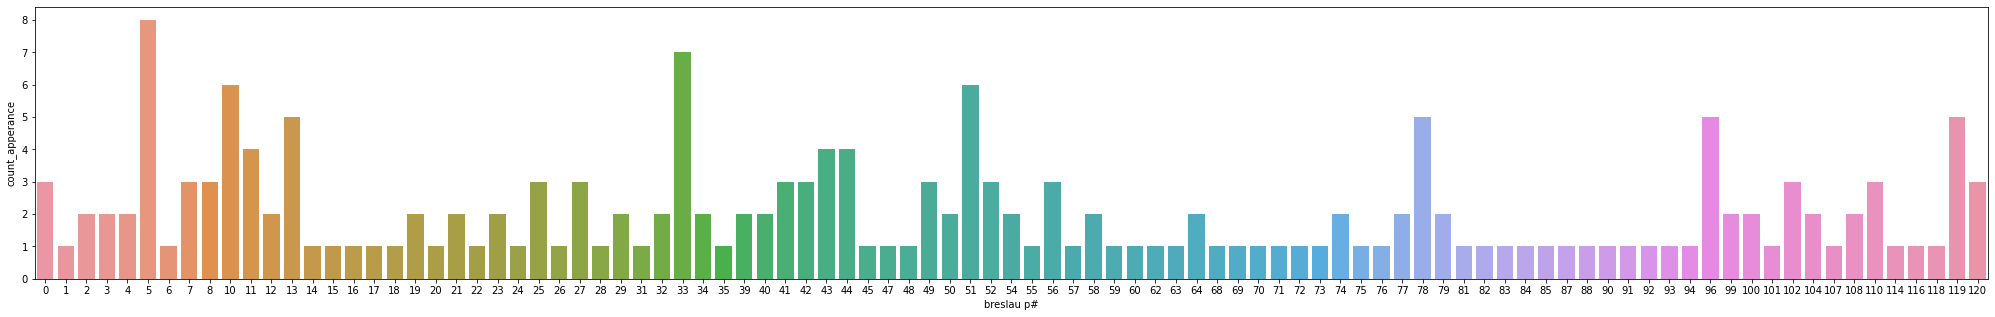

In [124]:
plt.figure(figsize=(35,5))
x = breslau_london_zwickau_p_aligment_by_shared_words.groupby(['breslau p#']).size().to_frame('count_apperance').reset_index()
sns.barplot(x='breslau p#', y='count_apperance', data=x)

<AxesSubplot:xlabel='breslau p#', ylabel='count_apperance'>

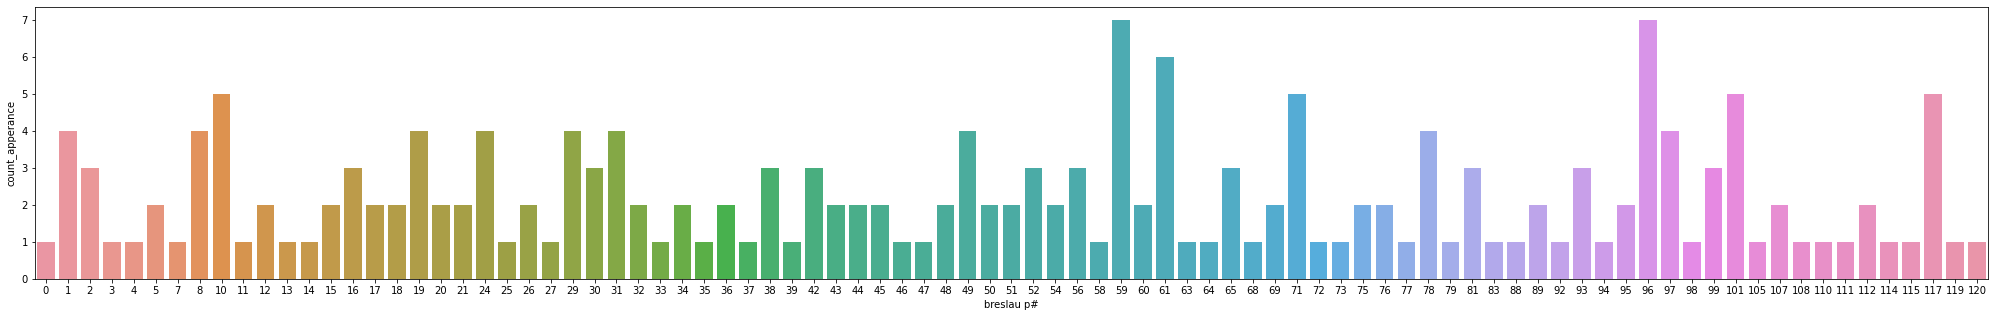

In [126]:
plt.figure(figsize=(35,5))
x = breslau_zwickau_london_p_aligment_by_shared_words.groupby(['breslau p#']).size().to_frame('count_apperance').reset_index()
sns.barplot(x='breslau p#', y='count_apperance', data=x)

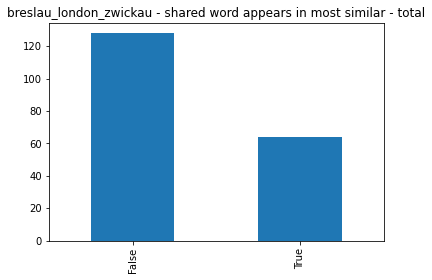

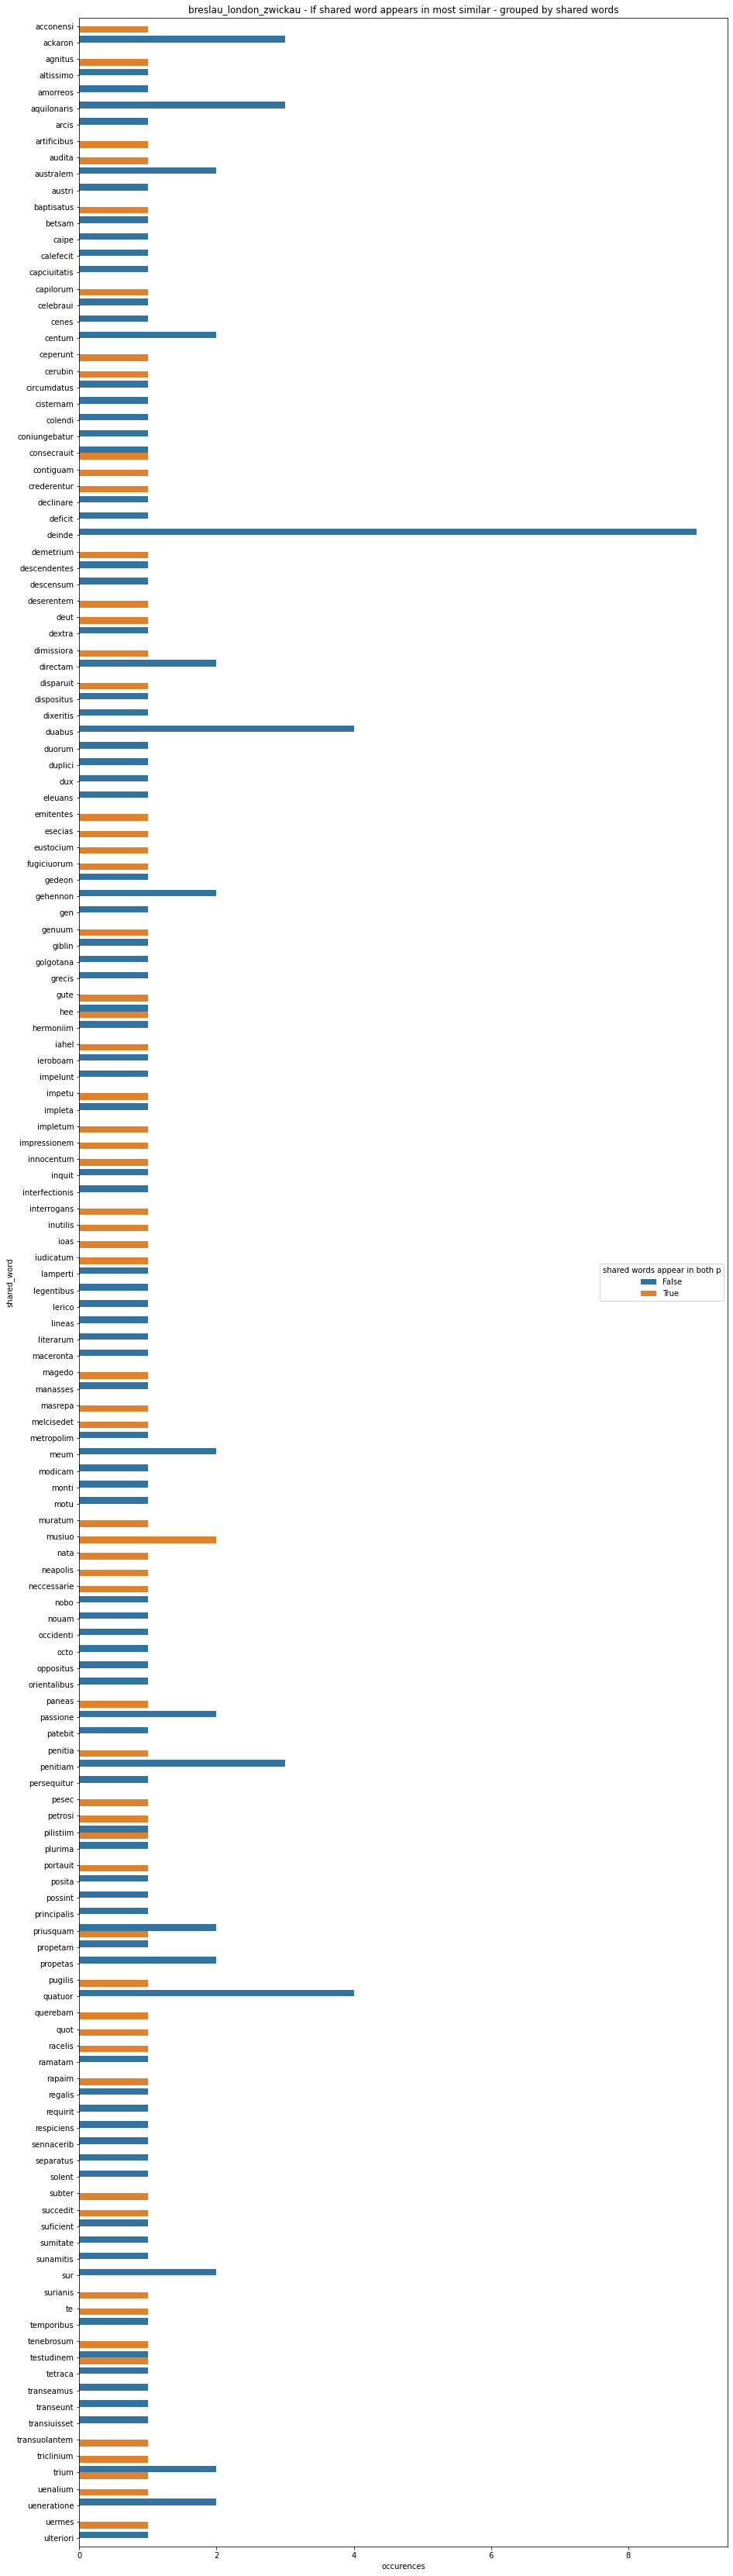

In [125]:
plot_shared_words(breslau_london_zwickau_p_aligment_by_shared_words, 'breslau_london_zwickau')

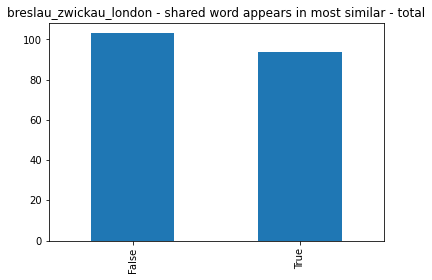

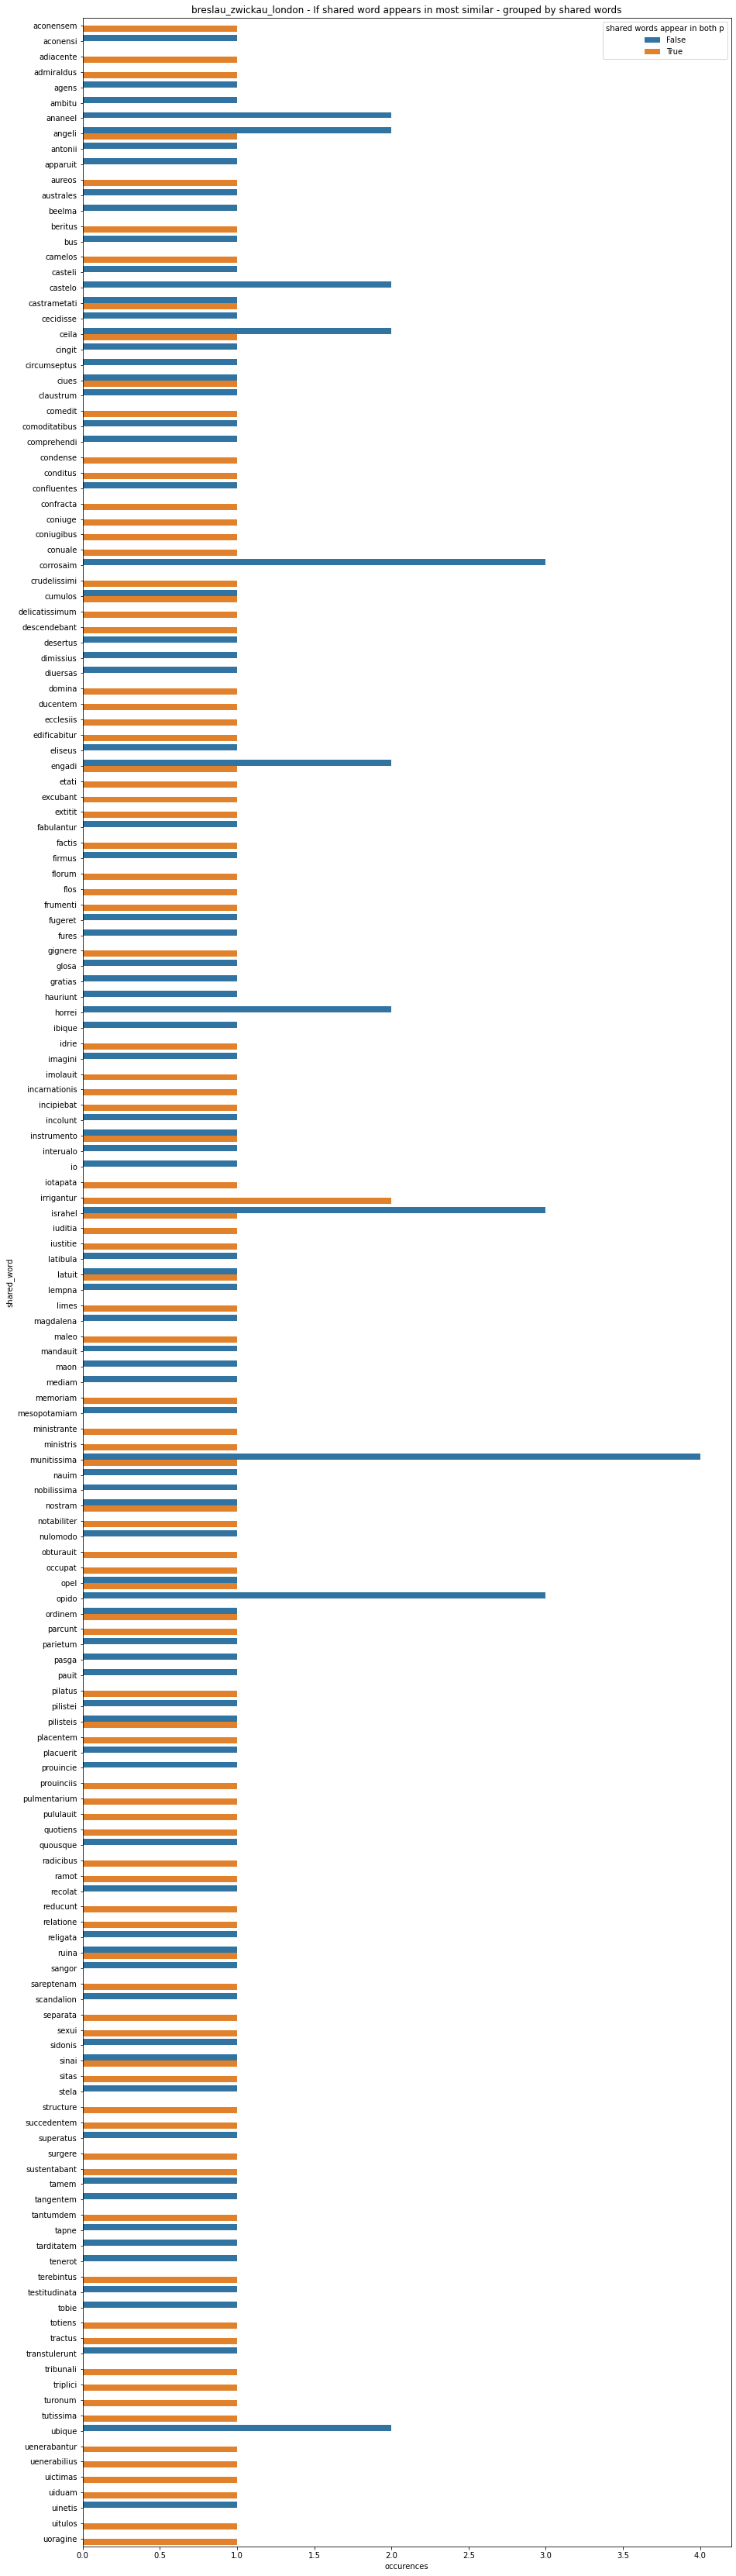

In [127]:
plot_shared_words(breslau_zwickau_london_p_aligment_by_shared_words, 'breslau_zwickau_london')

# vocabulary mapping - mapper before/after processing
in our last meeting at 3.4.22 I presented result that were made after total text cleanup according to Yoni table,

he asked if we can create map of words before change and after in order to provide easier understanding of the context

in order to be able easily to investigate preprocessed text we need ot create words map before->after

in order to be able to see source of preprocessed text

In [300]:
def create_pre_post_processing_map(raw_text):    
    data = []
    counts = Counter(''.join(raw_text.split('\n')).split(' '))
    for word in counts:
        resp = thesisTextCleanUp.create_corpus_by_line(text_cleanup.jvtext(word))
        if len(resp) == 0: continue
#         [post_proceced_word]=thesisTextCleanUp.create_corpus_by_line(text_cleanup.jvtext(word))
        data.append([word, resp[0]])
    return pd.DataFrame(data, columns=['before', 'after'])

In [301]:
def create_3_versions_pre_post_processing_maps():
    london_pre_post = create_pre_post_processing_map(thesisDataReader.read_london())
    zwickau_pre_post = create_pre_post_processing_map(thesisDataReader.read_zwickau())
    breslau_pre_post = create_pre_post_processing_map(thesisDataReader.read_breslau())
    
    london_pre_post.to_csv('../computed_data/vocabulary/pre_post_processing_mapping/london.csv')
    zwickau_pre_post.to_csv('../computed_data/vocabulary/pre_post_processing_mapping/zwickau.csv')
    breslau_pre_post.to_csv('../computed_data/vocabulary/pre_post_processing_mapping/breslau.csv')

In [302]:
create_3_versions_pre_post_processing_maps()

# Tests

In [299]:
imp.reload(thesisCleanUp)
%run ../src/text_cleanup/text_cleanup.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [37]:
imp.reload(thesisUtils)
%run ../src/utils/utils.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [87]:
imp.reload(thesisVocabulary)
%run ../src/vocabulary/vocabulary.test.py

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
